# CSCI 4622 - Spring 2018 - Practicum 
***


This practicum is due on Moodle by **11:59pm on Thursday May 3rd**. 

**Here are the rules:** 

4. Your work must be done entirely on your own. You may **NOT** collaborate with classmates or anyone else.  
3. You may **NOT** post to message boards or other online resources asking for help. 
5. You may **NOT** use late days on the practicum nor can you drop your practicum grade. 
1. You may use your course notes, posted lecture slides, in-class notebooks, and homework solutions as resources. 
2. You may consult alternate sources like blog posts or technical papers, but you may **NOT** copy code from these sources. 
3. Any additional non-course sources that you use should be clearly cited (with links) in the **References** section at the bottom of this notebook. 
7. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. 

Violation of the above rules will result in an **F** in the course and a trip to **Honor Council** 

***

**By writing your name below you agree to abide by the given rules:**

**Name**: Maxwell Lambek

**Kaggle Username**: mlambek

***


**NOTES**: 

- You do not need to implement everything from scratch.  At this point you should be leveraging Sklearn as much as you can. 
- If you have a clarifying question, please post it as a **PRIVATE** message to me on Piazza. 
- Part of the goal of this assignment is to see if you can stand on your own.  Please do not ask me to help you debug code or check if your answers are correct. Most of the implementation details necessary to complete this practicum can be found in the Hands-On notebooks or the Sklearn documentation.  
- You'll notice that the point totals below do not add up to 100.  This is because 10 out of the 100 points will be attributed to **style**.  To earn full credit for style your analysis should be concise and well-organized, your code should be readable and well-commented, and you should use plots and graphics to support your conclusions whenever appropriate.  

In [2]:
import pickle, gzip 
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

### [35 points] Problem 1: Building Classifiers for Fashion MNIST 
***

The classic MNIST Handwritten Digit data set has been a staple in the machine learning literature since the beginning of time (i.e. the late 90's).  However, machine learning practitioners have grown tired of the rusty digits and have recently begun to create and explore new, more interesting data sets. Some popular alternatives to emerge recently are [EMNIST](https://www.kaggle.com/crawford/emnist), [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist), and [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist). In this problem you will explore the latter. 

Fashion MNIST is comprised of $28 \times 28$ pixel gray-scale images of clothing, with classes corresponding to things like tops, trousers, coats, dresses, and various types of shoes.  The data set that we'll work with corresponds to a small subset of Fashion MNIST with 1500 examples from each of five distinct classes (tops, trousers, coats, sneakers, and ankle boots). 

Execute the following cell to load the data. 

In [2]:
f = gzip.open('data/fashion_mnist_subset.pklz', 'rb')
X_all, y_all = pickle.load(f)
f.close()

In **Parts A-C** you will construct various tuned classifiers for making predictions on Fashion MNIST.  For each classifier you should: 
- Describe and motivate any transformations on the pixel data that you found helpful/necessary to make your model work well. 
- Describe and justify your process for determining optimal hyperparameters for each model. Support your decisions with validation studies and associated graphics.  Do **NOT** just report the hyperparameters that worked best.  
- Describe how you evaluated your models during your process (i.e. did you use a validation set, did you do cross-validation, etc). 
- Report the final optimal hyperparameters that you used as well as the accuracy of your final model. 

**Part A**: Construct a K-Nearest Neighbors classifier to make predictions on the data. 

In [3]:
def error_rate(C): # to calculate the error rate of the model
    # diagnoal entries are the correct ones so we want to subtract them out
    return 1- (np.sum(np.diag(C)))/C.sum()

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
CVerrors = []
for k in range(2,30,2):# prefrom 5-fold cross validation for k values in the given range
    skf = StratifiedKFold(n_splits=5,shuffle=True)
    acc_valid = []
    for train_index, test_index in skf.split(X_all, y_all):
        Xt, Xv = X_all[train_index], X_all[test_index]
        yt, yv = y_all[train_index], y_all[test_index]
        knn = KNeighborsClassifier(k).fit(Xt, yt)# Make the KNN classifier and fit it to the split data
        y_hat = knn.predict(Xv)
        cm = confusion_matrix(yv,y_hat)
        acc_valid = acc_valid + [error_rate(cm)]# calculate the error and save the value
    CVerrors = CVerrors + [np.mean(acc_valid)]
    print("iteration: ", k, " error: ", np.mean(acc_valid))

iteration:  2  error:  0.038
iteration:  4  error:  0.0341333333333
iteration:  6  error:  0.0345333333333
iteration:  8  error:  0.0366666666667
iteration:  10  error:  0.0372
iteration:  12  error:  0.0385333333333
iteration:  14  error:  0.0402666666667
iteration:  16  error:  0.0398666666667
iteration:  18  error:  0.0418666666667
iteration:  20  error:  0.0413333333333
iteration:  22  error:  0.0432
iteration:  24  error:  0.0429333333333
iteration:  26  error:  0.0429333333333
iteration:  28  error:  0.0434666666667


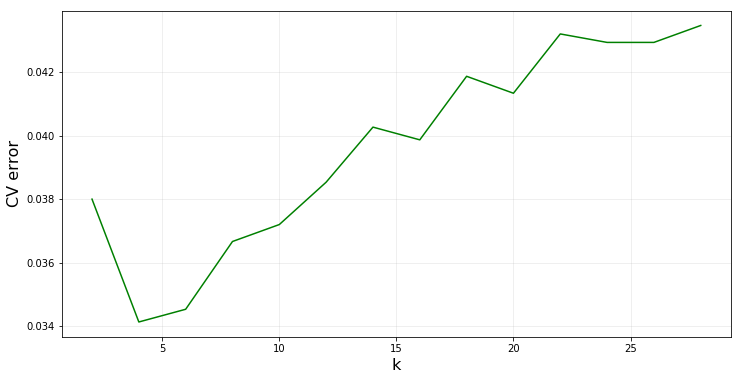

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(range(2,30,2),CVerrors, color = "green")
ax.set_xlabel("k", fontsize=16)
ax.set_ylabel("CV error", fontsize=16);
ax.grid(alpha=0.25)
ax.legend(loc="lower right", fontsize=16);

To determine an optimal value for $k$ I trained KNN predictors with k values between $0$ and $30$. I used 5 fold cross-validation to determine the accuracy of each model during the process the above plot shows the cross-validation error rates for each $k$ that I tested.

The optimal value for $k$ was, $k=4$ and the model had a cross-validation accuracy of $96.6\%$.

**Part B**: Construct a Linear Support Vector Machine classifier to make predictions on the data. 

In [7]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV


c_range = np.logspace(-2,3,5)
g_range = np.logspace(-9,3,5)
param_grid = dict(gamma=g_range, C=c_range)
# do a grid search with 3-fold cross validation to find the optimal values of c and gamma
grid = GridSearchCV(SVC(kernel="linear"), param_grid=param_grid, cv=3)
grid.fit(X_all, y_all)# fit the grid


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': array([  1.00000e-09,   1.00000e-06,   1.00000e-03,   1.00000e+00,
         1.00000e+03]), 'C': array([  1.00000e-02,   1.77828e-01,   3.16228e+00,   5.62341e+01,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [46]:
grid.best_estimator_

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0000000000000001e-09,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [47]:
print(grid.best_params_)
grid.best_score_

{'C': 0.01, 'gamma': 1.0000000000000001e-09}


0.96026666666666671

To determine optimial hyperparamters I decided to use a grid search with resonalbe ranges for $\gamma$ and C. I used 3 fold cross-validation to evaluate my model during the process because the runtime was already very long, and doing something higher then 3 fold cross-validation would only make it take signficantly longer.

The optimal hyperparamters were, $\gamma = 1.0*10^{-9}$ and $C = 0.01$. With those paramters the cross-validation accuracy of the final model was, $96.03\%$

**Part C**: Construct a Feed-Forward Neural Network classifier to make predictions on the data. We recommend using Sklearn's [MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) rather than the code you wrote in Homework 4. In our experiments we found training an MLPClassifier to take no more than a minute for reasonable choices of architectures. 

In [43]:
from sklearn.neural_network import MLPClassifier

CVerrors = []
for ii in range(10,520,50):
    skf = StratifiedKFold(n_splits=5,shuffle=True)
    acc_valid = []
    for train_index, test_index in skf.split(X_all, y_all):
        Xt, Xv = X_all[train_index], X_all[test_index]
        yt, yv = y_all[train_index], y_all[test_index]
        # Fit a neural network with ii being the amount of hidden layer nodes
        nn = MLPClassifier(hidden_layer_sizes=(ii),activation='logistic',alpha=0.01)
        nn.fit(Xt,yt)
        acc = nn.score(Xv,yv)
        acc_valid = acc_valid + [acc]# store the error for the current fold
    CVerrors = CVerrors + [np.mean(acc_valid)]
    print("hidden layer: ", ii, " accuracy: ", np.mean(acc_valid))

iteration:  10  error:  0.951066666667
iteration:  60  error:  0.951066666667
iteration:  110  error:  0.952666666667
iteration:  160  error:  0.953866666667
iteration:  210  error:  0.954266666667
iteration:  260  error:  0.953866666667
iteration:  310  error:  0.953466666667
iteration:  360  error:  0.954933333333
iteration:  410  error:  0.953466666667
iteration:  460  error:  0.954266666667
iteration:  510  error:  0.952666666667


Since this dataset is not linearly seperable, and the data is not extremly complicated I decided to go with a single hidden layer nerual network. Then, to determine the optimal amount of of neurons in the hidden layer I used cross-validation on neural networks with each iteration having 50 more nodes in the hidden layer. I looked at hidden layers having an amount of nodes somwhere between the input layer, and the output layer because it doesn't make much sense to have less nodes in the hidden layer then the output layer, and using more nodes then the input layer would be like overfitting. The result is that a neural net with anywhere between 510 and 110 nodes in the hidden layer is optimal.

I also tested a few different $\alpha$'s and anything smaller then 0.1 prefomed nearly the same so I decided to just use a resonably small $\alpha = 0.01$

So, the final paramaters I used was a neural network with $360$ nodes in the hidden layer and $\alpha = 0.01$, and the accuracy was $95.49\%$

**Part D**: Which of the three models above performed the best on the data set?  Were you surprised or not surprised by your results?  Discuss. 

KNN prefomed the best with 0.96614 accuracy. I was expecting a neural network to preform the best with a linear support vector machine being a very close second but, I was completely wrong! The neural network preformed the worst being half a percent behind the SVM, and being over one percent behind KNN.

**Part E**: For the best model you identified in **Part D**, perform a train-validation split and construct a confusion matrix based on predictions on the validation set.  Which classes tend to get confused with each other the most? Are there any classes for which your model performs exceptionally well?  Plot at least one misclassified example from each of the often-confused classes and suggests reasons why this behavior might occur.   

[[295   1   4   0   0]
 [  5 292   3   0   0]
 [  4   1 295   0   0]
 [  0   0   0 280  20]
 [  0   0   1  18 281]]


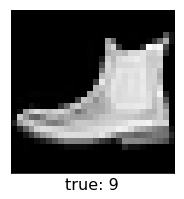

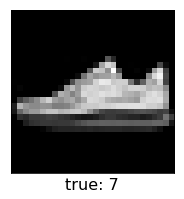

In [75]:
print(cm)
def view_digit(x, label=None):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(x.reshape(28,28), cmap='gray');
    plt.xticks([]); plt.yticks([]);
    if label: plt.xlabel("true: {}".format(label), fontsize=16)
view_digit(X_all[14],y_all[14])
view_digit(X_all[5],y_all[5])

From the confusion matrix we can see that class 9 and class 7 get missclassified with eachother the most commonly. class 0 occationaly gets confused with 1 and 4, and class 1 has the best preformance with only 10 total false positives and false negatives.

### [30 points] Problem 2: Predicting Authors of Presidential Election Tweets 
***

For the first time in history, the run-up to the 2016 presidential election saw candidates move a large portion of their campaigns from the traditional debating lectern to the Twitterverse. In this problem you will construct various classifiers to predict whether a tweet was sent by @HillaryClinton ($y=0$) or @realDonaldTrump ($y=1$). 

The data set contains $4000$ tweets that have been cleaned by converting all text to lowercase, removing punctuation, and removing hypertext links. In order to preserve hashtags we've replaced the typical # with the string `hashtag` (e.g. `#GiantMeteor` would be converted to `hashtaggiantmeteor`).  

Execute the following cell to load the data. 

In [3]:
f = gzip.open('data/clean_tweets.pklz','rb')
text_all, y_all = pickle.load(f)
f.close()

**Part A**: Vectorize the text features using the Bag-of-Words text model **while removing stop words**.  Then answer the following questions: 

- How many distinct text features are there in the data after stop words are removed? 
- How many distinct **HashTags** are there in the data? 
- Which candidate uses HashTags the most frequently? 

In [4]:
from sklearn.feature_extraction.text import CountVectorizer 
bagofwords = CountVectorizer(stop_words = 'english')
Xbw_train = bagofwords.fit_transform(text_all)
print("There are {:d} terms in the vocabular".format(Xbw_train.shape[1]))

There are 7509 terms in the vocabular


In [6]:
uniqueHashTags = 0
for word in bagofwords.vocabulary_:
    if word[0:7]=='hashtag':
        uniqueHashTags = uniqueHashTags +1
print("There are {:d} distinct HashTags in the data".format(uniqueHashTags))

hashtagwiprimary
hashtagtrump2016
hashtagamericafirst
hashtagbenghazi
hashtagdebates2016
hashtagdebatenight
hashtagmaga
hashtagdebates
hashtagde
hashtagwemadehistory
hashtagmakeamericagreatagain
hashtagrncincle
hashtagtrumppence16
hashtagdemsinphilly
hashtagimwithyoutickets
hashtagneverhillary
hashtagflashbackfriday
hashtagrollcallvote
hashtagdemconvention
hashtagvotetrumpny
hashtagwomen4ttump
hashtagimwithyou
hashtagrip
hashtagjuangabriel
hashtagdivodejuarez
hashtagpotus
hashtagmakeamericasafeagain
hashtagtrump20166
hashtagdeclareyourambition
hashtagcrookedhillary
hashtagnps100
hashtagnyprimary
hashtagmakeamericagreatagainvideo
hashtagdday
hashtagvotetrump
hashtagblackmenforbernie
hashtaghillary2016
hashtagblacksfortrump
hashtagtrumppence2016
hashtagfrozen
hashtagarizonaprimary
hashtagazprimary
hashtagdncinphl
hashtagusa
hashtagsecondamendment
hashtag2a
hashtagnabjnahj16
hashtagtrumptrain
hashtagvotetrump2016
hashtagfollowthemoney
hashtagnewyorkvalues
hashtagnevertrump
hashtaglovetrum

In [15]:
trump_count = 0
clinton_count = 0
ii = 0
for tweet in text_all:
    if y_all[ii] == 0:
        clinton_count = clinton_count + tweet.count('HASHTAG')
    else:
        trump_count = trump_count + tweet.count('HASHTAG')
    ii = ii + 1
        
print("Clinton used {:d} HashTags".format(clinton_count), "and Trump used {:d} HashTags".format(trump_count))
print("So, Trump uses HashTags much more frequently")

Clinton used 258 HashTags and Trump used 804 HashTags
So, Trump uses HashTags much more frequently


**Part B**: Construct a Logistic Regression classifier with L2 regularization to make predictions on the data. Exactly as in **Problem 1**, you should clearly detail your process for picking optimal hyperparameters and evaluating your model, and report the details of your best model along with final validation accuracy. 

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
c_range = np.logspace(-1,3,30)
CVerrors = []
for c in c_range:
    arr_text_all = np.asarray(text_all)
    skf = StratifiedKFold(n_splits=10,shuffle=True)
    acc_valid = []
    for train_index, test_index in skf.split(text_all, y_all):
        # make a pipline to do both vectorizing and regression
        bagofwords_steps = [
        ("bagofwords", TfidfVectorizer(stop_words="english")),
        ("logreg", LogisticRegression(C=c))]
        Xt, Xv = arr_text_all[train_index], arr_text_all[test_index]
        yt, yv = y_all[train_index], y_all[test_index]
        bagofwords_pipe = Pipeline(bagofwords_steps).fit(Xt,yt)
        #bagofwords_pipe.fit(Xt, yt)
        acc = bagofwords_pipe.score(Xv, yv)
        acc_valid = acc_valid + [acc]

    print("for c =", c, "accuracy:", np.mean(acc_valid))
    CVerrors = CVerrors + [np.mean(acc_valid)]

for c = 0.1 accuracy: 0.89025
for c = 0.137382379588 accuracy: 0.89725
for c = 0.188739182214 accuracy: 0.90075
for c = 0.25929437974 accuracy: 0.906
for c = 0.356224789026 accuracy: 0.907
for c = 0.489390091848 accuracy: 0.91
for c = 0.67233575365 accuracy: 0.91325
for c = 0.923670857187 accuracy: 0.91725
for c = 1.26896100317 accuracy: 0.9135
for c = 1.7433288222 accuracy: 0.916
for c = 2.39502661999 accuracy: 0.91875
for c = 3.29034456231 accuracy: 0.921
for c = 4.52035365636 accuracy: 0.91975
for c = 6.21016941892 accuracy: 0.92075
for c = 8.53167852417 accuracy: 0.9255
for c = 11.7210229753 accuracy: 0.92475
for c = 16.1026202756 accuracy: 0.92375
for c = 22.1221629107 accuracy: 0.92675
for c = 30.3919538231 accuracy: 0.92275
for c = 41.7531893656 accuracy: 0.92625
for c = 57.3615251045 accuracy: 0.92025
for c = 78.8046281567 accuracy: 0.9245
for c = 108.263673387 accuracy: 0.9265
for c = 148.735210729 accuracy: 0.92025
for c = 204.335971786 accuracy: 0.92125
for c = 280.721620394

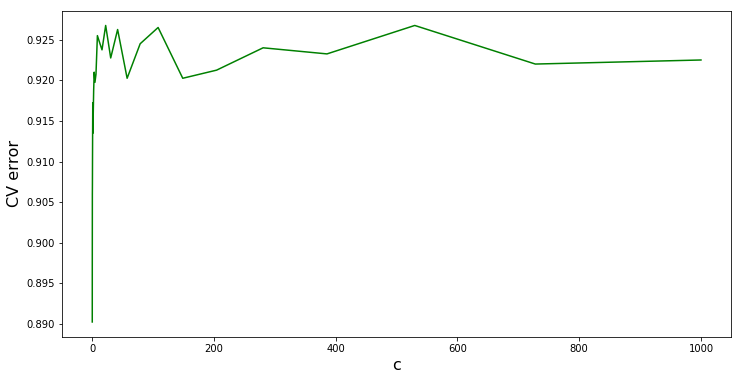

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(c_range,CVerrors, color = "green")
ax.set_xlabel("c", fontsize=16)
ax.set_ylabel("CV error", fontsize=16);

I found the optimal C value by building a somewhat resonable range for C, and then running 10-Fold Cross Validation on that value of C. I then took the smallest value of C from when the accuracy didn't improve much from. By doing this process I found that the $C=22$ was optimal with CV accuracy: $92.68\% $

**Part C**: Determine and report the 10 words that are the best predictors for @HillaryClinton and the 10 words that are the best predictors for @realDonaldTrump in your Logistic Regression model. In addition, you should briefly discuss how you found these best features mathematically. 

In [261]:

bagofwords = TfidfVectorizer(stop_words = 'english')
bowf = bagofwords.fit_transform(text_all,y_all)
logreg = LogisticRegression(C=16, tol = 1e-6)
logreg.fit(bowf,y_all)
logreg.coef_

features = np.asarray(bagofwords.get_feature_names())
top10 = np.argsort(logreg.coef_[0])[-10:]
bottom10 = np.argsort(logreg.coef_[0])[:10]
print("DT: %s" % " ".join(features[top10]))
print("HC: %s" % " ".join(features[bottom10]))

    

DT: speech hashtagtrump2016 hashtagamericafirst cnn great hashtagmakeamericagreatagain realdonaldtrump media clinton crooked
HC: rt timkaine potus trump trumps barack joebiden hillary flotus billclinton


The best features are the features with the highest coefficient. The coefficients are determined by using stochastic gradient descent to update the logistic regression model until the model doesn't improve between iterations. Stochastic gradient descent is a method of using the gradient of the model to iteratively update the coefficients to find the best set of coefficients.

**Part D**: Construct a Naive Bayes classifier to make predictions on the data. Again, you should clearly detail your process for picking optimal hyperparameters and evaluating your model, and report the details of your best model along with final validation accuracy. **Hint**: Since text features are discrete, you'll want to use Sklearn's [MultinomialNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) classifier. 

In [271]:
from sklearn.naive_bayes import MultinomialNB

alpha_range = np.logspace(-2,1,30)

CVerrors = []
for alpha in alpha_range:
    arr_text_all = np.asarray(text_all)
    skf = StratifiedKFold(n_splits=10,shuffle=True)
    acc_valid = []
    for train_index, test_index in skf.split(text_all, y_all):
        # make pipline for vectorizing and building the classifer
        bagofwords_steps = [
        ("bagofwords", CountVectorizer(stop_words="english")),
        ("clf", MultinomialNB(alpha=alpha, fit_prior=False))]
        Xt, Xv = arr_text_all[train_index], arr_text_all[test_index]
        yt, yv = y_all[train_index], y_all[test_index]
        bagofwords_pipe = Pipeline(bagofwords_steps)
        bagofwords_pipe.fit(Xt, yt) # fit the vectorizer and classifier with the data
        acc = bagofwords_pipe.score(Xv, yv)
        acc_valid = acc_valid + [acc]

    print("for alpha =", alpha, "accuracy:", np.mean(acc_valid))
    CVerrors = CVerrors + [np.mean(acc_valid)]

for alpha = 0.01 accuracy: 0.91825
for alpha = 0.0126896100317 accuracy: 0.914
for alpha = 0.0161026202756 accuracy: 0.91775
for alpha = 0.0204335971786 accuracy: 0.9185
for alpha = 0.025929437974 accuracy: 0.9215
for alpha = 0.0329034456231 accuracy: 0.9215
for alpha = 0.0417531893656 accuracy: 0.92575
for alpha = 0.0529831690628 accuracy: 0.923
for alpha = 0.067233575365 accuracy: 0.9235
for alpha = 0.0853167852417 accuracy: 0.9225
for alpha = 0.108263673387 accuracy: 0.92575
for alpha = 0.137382379588 accuracy: 0.92875
for alpha = 0.17433288222 accuracy: 0.92525
for alpha = 0.221221629107 accuracy: 0.92625
for alpha = 0.280721620394 accuracy: 0.927
for alpha = 0.356224789026 accuracy: 0.92775
for alpha = 0.452035365636 accuracy: 0.933
for alpha = 0.573615251045 accuracy: 0.931
for alpha = 0.727895384398 accuracy: 0.92925
for alpha = 0.923670857187 accuracy: 0.92775
for alpha = 1.17210229753 accuracy: 0.9275
for alpha = 1.48735210729 accuracy: 0.92525
for alpha = 1.88739182214 accura

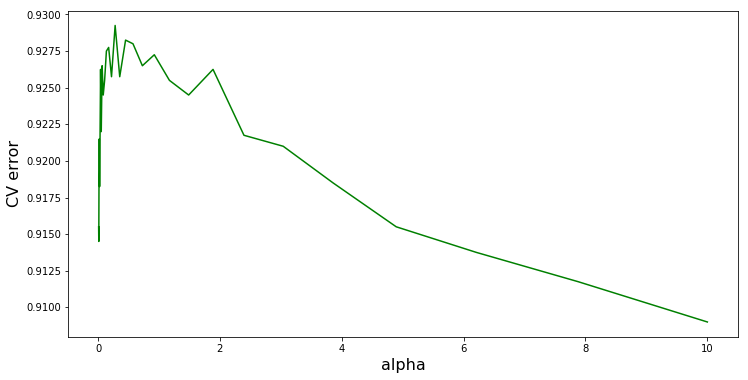

In [269]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(alpha_range,CVerrors, color = "green")
ax.set_xlabel("alpha", fontsize=16)
ax.set_ylabel("CV error", fontsize=16);

I found the optimal $\alpha$ value by building a somewhat resonable range for $\alpha$, and then running 10-Fold Cross Validation on that value of $\alpha$. I then took the smallest value of $\alpha$ from when the accuracy didn't improve much from. I also looked at if fitting the prior or not fitting the prior is better for each value of $\alpha$ but, I didn't see any significant differences between the two options. By doing this process I found that the $\alpha=0.45203$ was optimal with CV accuracy: $93.3\%$.

**Part E**: Determine and report the 10 words that are the best predictors for @HillaryClinton and the 10 words that are the best predictors for @realDonaldTrump in your Naive Bayes model. In addition, you should briefly discuss how you found these best features mathematically. 

In [162]:

bagofwords = CountVectorizer(stop_words = 'english')
bowf = bagofwords.fit_transform(text_all,y_all)
clf = MultinomialNB(alpha=0.0853167852417)
clf.fit(bowf, y_all)
features = np.asarray(bagofwords.get_feature_names())
top10 = np.argsort(clf.coef_[0])[-10:]
bottom10 = np.argsort(clf.coef_[0])[:10]
print("DT: %s" % " ".join(features[top10]))

DT: people hashtagtrump2016 amp trump clinton crooked realdonaldtrump great hillary thank


The words that have the highest probabilites for a class are the words that are the best predictors. The probabilites are found by looking at how frequently a word shows up in a class, and the more often a word shows up the higher the probability it gets for that class i.e. $\hat{p}(WORD|Class) = \frac{\# \text{instances of WORD in Class}}{\# \text{total number of words in the Class}} $

**Part F**: Which of the two models above performed the best on the data set?  Were you surprised or not surprised by your results?  Discuss. 

The Naive Bayes model prefomed better than Logistic Regression. I am not surprised by this becuase tweets are relatively short, simple, and can be very fragmented. So, a classifier that just looks at individual words, weights them, and calculates probabilites directly off of those words seems like it should preform better than a classifier that uses regression to make classifications. The Nieve Bayes model also works well on smaller sets of data and since the dataset that is being used here is relatively small I would expect Nieve Bayes to prefrom well. With feature engineering I would guess that the Logisitc Regression classifier would preform better because now there are more specificly constructed features to help seperate the two classes.

### [25 points] Problem 3: Feature Engineering and Presidential Tweets 
***

In this problem you will again work with the Twitter election data from **Problem 2**, but this time in its unadulterated raw form. Unlike in **Problem 2**, you will only be allowed to use Logistic Regression as your classifier.  Instead of using a fancier model, you will attempt to improve performance by crafting better features.  One way you might do this is to explore text models that are more sophisticated that simple Bag-of-Words. Alternatively, you might explore the training data and identify characteristics of tweets by a particular author that you can then turn into a feature. 

The class `TweetFeaturizer` shown below is already fully functional.  Your goal in this problem is to make it better.  In it's current state, the class reads in the training and test data, fits a Logistic Regression model using Bag-of-Words, makes predictions on the test set, and then dumps the predictions to a csv file that can be uploaded to Kaggle. You are free to modify this class is any way that you see fit, but we've given you some helpful functionality that will prove sufficient for most of you.  The `add_text_features` method currently loops over each tweet in the data set, copies it to a new array, and then passes that array into the text vectorizer.  One way to create new features is to append distinct word-indicators onto the string representing the tweet.  These will then be turned into features by the vectorizer. 

As an example (that is intentionally silly and probably unhelpful): Suppose you think a potentially helpful feature is whether or not the tweet contains more than 10 instances of the letter `z`.  In `add_text_features` you could count the number of `z`'s in a tweet and if there are more than 10, you could append the word `MoreThanTenZs` to the tweet.  Then, when the tweet is passed into the vectorizer, this will turn into a numerical feature.  

In addition to competing against yourself to craft the best features that you can, you'll also compete against your classmates in a Kaggle competition.  The competition page can be found here: 

https://www.kaggle.com/c/4622-election-tweet-authorship

A private invite link will be available on Piazza which will get you into the competition. Note that the test data has been partitioned into a public leaderboard set and a private leaderboard set.  While the competition is open, submitting to Kaggle will tell you your score on the public leaderboard.  Your scores on the private leaderboard will become available at the end of the competition.   The top **THREE** students on the **Private** leaderboard at the end of the competition will earn 10 extra credit points on the Practicum. Note that to prevent the machine learning-equivalent of button mashing, we've limited you to **10** submissions per day.  You should be evaluating your features locally with cross-validation and then submitting to Kaggle when you think you have something that works.  

**Part A**: **Feature Engineering**:  What you need to do: 

- Explore and experiment with the data to try to find good features 
- Implement these features in the `TweetFeaturizer` class  
- Implement some evaluation methods to see how well your features improve your model (*cough* cross-validation *cough*) 
- Make submissions to the Kaggle competition and see how you compared to your classmates 

In [21]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
f = gzip.open('data/raw_tweets_train.pklz','rb')
text_train, y_train = pickle.load(f)
f.close()
trc = 0
clc = 0
clh = 0
trh = 0
tweetath = 0
tweetatt = 0
ii = 0
puncs = 0
import string
puncuations = set(string.punctuation)

for ex in text_train:
    # check if there is puncuaiton or not
    if any(char in puncuations for char in ex):
        puncs = puncs+1
    # if Clinton how many works, #'s, and @'s
    if y_train[ii] == 0:
        clc+=len(ex.split())
        clh +=ex.count('#')
        tweetath += ex.count('@')
        
    # if Trump how many works, #'s, and @'s
    else:
        tweetatt += ex.count('@')
        trc+=len(ex.split())
        trh +=ex.count('#')
    ii = ii + 1
print(puncs)
print(tweetath/(np.sum(y_train == 0))) # so trump tweets at people more than clinton
print(tweetatt/(np.sum(y_train == 1)))

print(clc/(np.sum(y_train == 0)))# so clinton writes longer tweets
print(trc/(np.sum(y_train == 1)))

print(clh/(np.sum(y_train == 0))) # Trump uses 3x more hashtags than clinton!
print(trh/(np.sum(y_train == 1)))

3998
0.5275
0.59
21.335
19.363
0.134
0.4415


**Part B**: **Motivation and Analysis**: What you need to do: 

Convince me that:

- Your new features work
- You understand what the new features are doing
- You had a clear methodology for incorporating the new features


Each individual feature made the 10-Fold Cross Validation accuracy go up slightly. Each text feature that I added was constructed from looking at how Clinton and Trump write tweets, and then added to the tweet to be vectorized by Tfidf. Once all the new features and the regular words are vectorized by Tfidf I added a method to take only the best features form the training set in order to prevent overfitting.

To come up with a new text feature I spent time looking at tweets by both Trump and Clinton, and then when I find something that might be consistently different for them I ran a quick calculation on it to see if the average result is different for them. Once all of those steps are completed I added the feature and checked to see if it improved the cross-validation accuracy.

Using the best features and Tfidf vectorizer improved the CV accuracy by around 3%, and then all of the text features added another 2.5% CV accuracy. On the Kaggle competition this improved my score to 3.2% above the baseline!

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import sklearn.feature_selection
#from sklearn.feature_selection import f_classif
class TweetFeaturizer:
    def __init__(self):
        
        from sklearn.feature_extraction.text import CountVectorizer
        from sklearn.feature_extraction.text import TfidfVectorizer
        

        self.vectorizer = TfidfVectorizer(stop_words = 'english', binary = True,sublinear_tf=True)
        #self.vectorizer = CountVectorizer(stop_words = 'english')
        
    def add_text_features(self, examples):
        """
        Method for looping over original text and adding new text 
        features. 
        :param examples: the list of raw tweets 
        """
        new_examples = [] 
        for ex in examples:
            
            #print(ex)
            splitstr = ex.split()
            uppercount = 0
            for word in splitstr:
                if word.isupper():
                    uppercount +=1

            if uppercount > 1:
                ex = ex + ' hasfulluppercasewords'
            if ex.count('-')>1:
                ex = ex + ' hashyphens'
            if ex.count('?')>=1:
                ex = ex + ' hasquestionmarks'
            if ex.count('!')>=1:
                ex = ex + ' multipleexclmation'
            if '...' in ex:
                ex = ex + ' manydotdotdots'
            if ex.count('@')>1:
                ex = ex + ' tweetedatsomone'
            if ex.count('http')>1:
                ex = ex + ' multiplelinkshere'
            # see if there are more uppercase letters than words
            if sum(1 for c in ex if c.isupper())>len(ex.split()):
                ex = ex + ' manyuppercaseletters'
            if ex.count('#')>=2:
                ex = ex + ' manyhashtags'
            if len(ex.split()) > 25:
                ex = ex + ' alotofwordshere'
            new_examples.append(ex)
            
        return new_examples

    def build_train_features(self, examples):
        """
        Method to take in training text features and do further feature engineering 
        Most of the work in this homework will go here, or in similar functions  
        :param examples: the list of raw tweets 
        """
        
        new_examples = self.add_text_features(examples)
        svf = self.vectorizer.fit_transform(new_examples)
        # select only the 1000 best features to reduce overfitting
        self.skb = SelectKBest(sklearn.feature_selection.f_classif,k=1000).fit(svf,self.y_train)
        newfeatures = self.skb.transform(svf)
        
        return newfeatures

    def get_test_features(self, examples):
        """
        Method to take in test text features and transform the same way as train features 
        :param examples: the list of raw tweets
        """
        new_examples = self.add_text_features(examples)
        svf = self.vectorizer.transform(new_examples)
        # using the 1000 best features transform the new data
        newfeatures = self.skb.transform(svf)
        
        return newfeatures

    def show_top10(self): 
        # This is very broken right now beucase select k best sorts the feature names differently
        # than just using Tfidf.
        """
        prints the top 10 features for the positive class and the 
        top 10 features for the negative class. 
        """
        feature_names = np.asarray(self.vectorizer.get_feature_names())
        top10 = np.argsort(self.logreg.coef_[0])[-10:]
        bottom10 = np.argsort(self.logreg.coef_[0])[:10]
        print("DT: %s" % " ".join(feature_names[top10])) 
        print("HC: %s" % " ".join(feature_names[bottom10]))
                
    def train_model(self, random_state=1234):
        """
        Method to read in training data from file, and 
        train Logistic Regression classifier. 
        
        :param random_state: seed for random number generator 
        """
        
        from sklearn.linear_model import LogisticRegression 
        
        # load data 
        f = gzip.open('data/raw_tweets_train.pklz','rb')
        text_train, y_train = pickle.load(f)
        f.close()
        
        # get training features and labels 
        self.y_train = y_train
        self.X_train = self.build_train_features(text_train)
        
        
        # train logistic regression model.  !!MUST USE LogisticRegression!!
        c_range = np.logspace(-1,3,30)
        #c_range = range(30,61,2)

        for param in c_range: # Test all the desired values of C
            skf = StratifiedKFold(n_splits=10,shuffle=True)
            acc_valid = []
            acc_train = []
            for train_index, test_index in skf.split(self.X_train, self.y_train): # do Cross-validation
                Xt, Xv = self.X_train[train_index], self.X_train[test_index]
                yt, yv = self.y_train[train_index], self.y_train[test_index]
                self.logreg = LogisticRegression( C = param,tol=1e-4)
                self.logreg.fit(Xt,yt)
                acc = self.logreg.score(Xv,yv)
                acc_valid = acc_valid + [acc]
                acc = self.logreg.score(Xt,yt)
                acc_train = acc_train + [acc]

            print("for c =", param, "valid accuracy:", np.mean(acc_valid),"train accuracy:", np.mean(acc_train) )
        
        
        # run the logistic regression on all of the data with the best C value for submitting to kaggle
        self.logreg = LogisticRegression(random_state=random_state, C = 10)
        self.logreg.fit(self.X_train, self.y_train)
        
    def model_predict(self):
        """
        Method to read in test data from file, make predictions
        using trained model, and dump results to file 
        """
        
        # read in test data 
        f = gzip.open('data/raw_tweets_test.pklz','rb')
        text_valid = pickle.load(f)
        f.close()
        
        # featurize test data 
        self.X_test = self.get_test_features(text_valid)
        
        # make predictions on test data 
        pred = self.logreg.predict(self.X_test)
        
        
        # dump predictions to file for submission to Kaggle  
        pd.DataFrame({"realDonaldTrump": np.array(pred, dtype=bool)}).to_csv("prediction2.csv", index=True, index_label="Id")
        

# Instantiate the class 
feat = TweetFeaturizer()

# Train your Logistic Regression classifier 
feat.train_model(random_state=1234)

# Show the top 10 features for each class 
#feat.show_top10() # commented because it's broken, and the awnsers are meaningless

# Make prediction on test data and produce Kaggle submission file 
feat.model_predict()

for c = 0.1 valid accuracy: 0.9095 train accuracy: 0.916166666667
for c = 0.137382379588 valid accuracy: 0.91175 train accuracy: 0.919305555556
for c = 0.188739182214 valid accuracy: 0.91575 train accuracy: 0.921305555556
for c = 0.25929437974 valid accuracy: 0.91625 train accuracy: 0.924527777778
for c = 0.356224789026 valid accuracy: 0.91825 train accuracy: 0.929583333333
for c = 0.489390091848 valid accuracy: 0.92325 train accuracy: 0.934666666667
for c = 0.67233575365 valid accuracy: 0.9275 train accuracy: 0.939777777778
for c = 0.923670857187 valid accuracy: 0.93 train accuracy: 0.944555555556
for c = 1.26896100317 valid accuracy: 0.93725 train accuracy: 0.94775
for c = 1.7433288222 valid accuracy: 0.93825 train accuracy: 0.952083333333
for c = 2.39502661999 valid accuracy: 0.94175 train accuracy: 0.956944444444
for c = 3.29034456231 valid accuracy: 0.945 train accuracy: 0.961111111111
for c = 4.52035365636 valid accuracy: 0.94475 train accuracy: 0.965055555556
for c = 6.210169418

### References
***



scikit-learn.org